In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings
import pandas as pd
pd.set_option('display.max_columns', None)
from tqdm.notebook import tqdm

root_path = "/data/mm/sr-press"
base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"base_path: {base_path}")
print(f"root_path: {root_path}")
sys.path.append(base_path)
sys.path.append(root_path)

base_path: /home/ubuntu/LMH/sr-press
root_path: /data/mm/sr-press


In [2]:
from express.databases import SQLiteDatabase
from express.datasets import PressingDataset

from express import features as fs
from express import labels as ls

/home/ubuntu/miniforge3/envs/mm/lib/python3.10/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# TRAIN_DB_PATH = os.path.join(base_path, "stores/train_database.sqlite")
# TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")
TRAIN_DB_PATH = os.path.join(root_path, "stores/train_database.sqlite")
TEST_DB_PATH = os.path.join(root_path, "stores/test_database.sqlite")


train_db = SQLiteDatabase(TRAIN_DB_PATH)
test_db = SQLiteDatabase(TEST_DB_PATH)

print("train_db:", train_db)
print("test_db:", test_db)

train_db: <express.databases.sqlite.SQLiteDatabase object at 0x7f58496f66b0>
test_db: <express.databases.sqlite.SQLiteDatabase object at 0x7f598169beb0>


In [4]:
print(train_db.games().shape, test_db.games().shape)

(151, 11) (49, 11)


In [5]:
all_features = [f.__name__ for f in fs.all_features]
all_labels = [f.__name__ for f in ls.all_labels]
print("Features:", all_features)
print("Labels:", all_labels)

Features: ['actiontype', 'actiontype_onehot', 'result', 'result_onehot', 'bodypart', 'bodypart_onehot', 'time', 'startlocation', 'relative_startlocation', 'endlocation', 'relative_endlocation', 'startpolar', 'endpolar', 'movement', 'team', 'time_delta', 'space_delta', 'goalscore', 'angle', 'under_pressure', 'packing_rate', 'ball_height_onehot', 'speed', 'freeze_frame_360', 'nb_opp_in_path', 'dist_opponent', 'defenders_in_3m_radius', 'closest_3_players', 'closest_11_players', 'expected_3_receiver_and_presser_by_distance']
Labels: ['concede_shots', 'counterpress', 'posession_change']


In [6]:
train_dataset = PressingDataset(
    # path= os.path.join(base_path, "stores", "datasets", "train"), 
    path= os.path.join(root_path, "stores", "datasets", "train"), 
    xfns=["startlocation", "closest_11_players", "freeze_frame_360"],
    # yfns=["counterpress"], 
    yfns=["posession_change"], 
    load_cached =False,
    nb_prev_actions = 3,
)

test_dataset = PressingDataset(
    # path= os.path.join(base_path, "stores", "datasets", "test"), 
    path= os.path.join(root_path, "stores", "datasets", "test"), 
    xfns=["startlocation", "closest_11_players", "freeze_frame_360"],
    yfns=["posession_change"], 
    load_cached =False,
    nb_prev_actions = 3,
)

In [30]:
train_dataset.create(train_db)
test_dataset.create(test_db)

  0%|          | 0/151 [00:00<?, ?it/s]

100%|██████████| 49/49 [00:27<00:00,  1.81it/s]


True

In [32]:
train_dataset.labels

posession_change
game_id action_id                  
3788741 3                      True
        19                     True
        27                     True
        31                    False
        35                    False
...                             ...
3943043 2283                   True
        2286                   True
        2302                  False
        2304                  False
        2309                   True

[39046 rows x 1 columns]

In [33]:
test_dataset.labels

posession_change
game_id action_id                  
3857255 6                     False
        17                    False
        22                    False
        25                    False
        40                    False
...                             ...
3895348 2818                  False
        2834                  False
        2847                  False
        2848                  False
        2853                   True

[12406 rows x 1 columns]

In [35]:
train_dataset.labels["posession_change"].value_counts()

posession_change
False    26746
True     12300
Name: count, dtype: int64

In [36]:
test_dataset.labels["posession_change"].value_counts()

posession_change
False    8596
True     3810
Name: count, dtype: int64

In [8]:
games_idx = train_db.games().index
game_id = games_idx[0]

In [9]:
from express.utils import add_names

actions = add_names(train_db.actions(game_id))
game_actions = actions.reset_index()
game_actions.head()

,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id,possession_team_id,play_pattern_name,under_pressure,duration,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
0,3788741,0,5c888f58-fe77-459b-ab3b-a2fa5fb8ab16,1,0.878,909,11086,52.0625,34.425,28.0000,43.945,5,0,1,909.0,From Kick Off,0,1.910504,"{'pass': {'recipient': {'id': 8963, 'name': 'C...","[[0.0, 44.39976078697438], [16.82907029647681,...",0,"[{'teammate': False, 'actor': False, 'keeper':...",pass,success,foot_right
1,3788741,1,bea4235d-7e40-461c-bb82-6d473f5bb324,1,2.789,909,8963,28.0000,43.945,31.2375,42.585,0,21,1,909.0,From Kick Off,0,1.499077,"{'carry': {'end_location': [36.2, 30.4]}}","[[30.27094296623723, 2.3520882891309185], [5.7...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",dribble,success,foot
2,3788741,2,84b9b798-0fbe-45bc-a4bf-3621959f29ce,1,4.288,909,8963,31.2375,42.585,61.4250,3.995,4,0,1,909.0,From Kick Off,0,2.476772,"{'pass': {'recipient': {'id': 8541, 'name': 'K...","[[31.00063614049526, 1.2150785249513518], [6.7...",0,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_left
3,3788741,3,6e2955cf-ad4f-4096-a4dd-053173a3802b,1,6.751,914,8286,63.2625,6.715,63.2625,6.715,0,23,0,909.0,From Kick Off,0,0.080000,{},"[[87.6897292922602, 68.0], [68.82521396005053,...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pressing,fail,foot
4,3788741,4,1615d483-101d-45c1-b554-04cf69897232,1,6.764,909,8541,61.4250,3.995,61.1625,4.250,0,21,1,909.0,From Kick Off,1,0.101747,"{'carry': {'end_location': [70.4, 75.5]}}","[[69.32405800689574, 0.0], [40.54450680816471,...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",dribble,success,foot


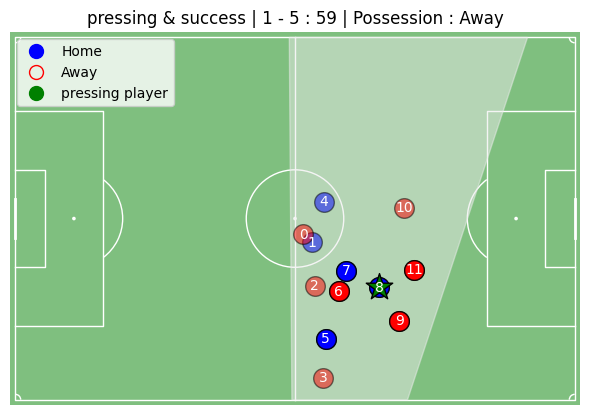

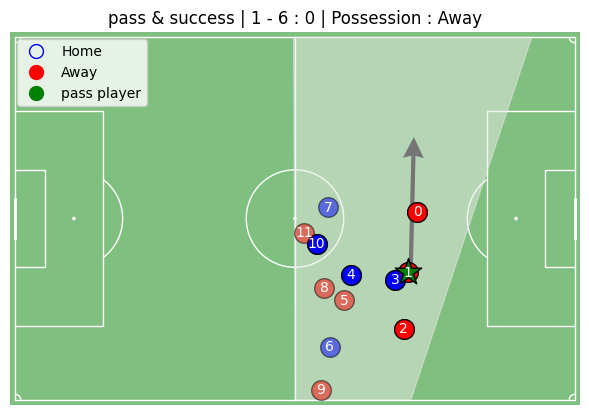

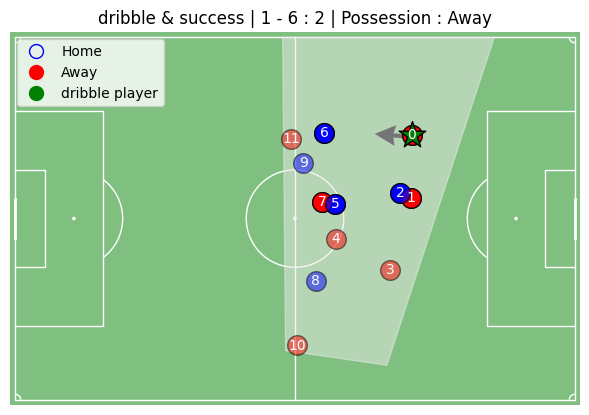

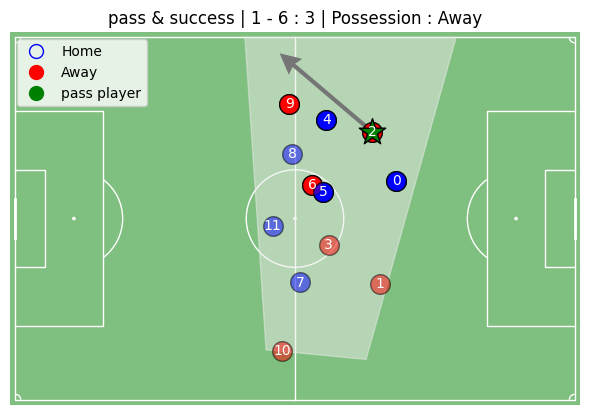

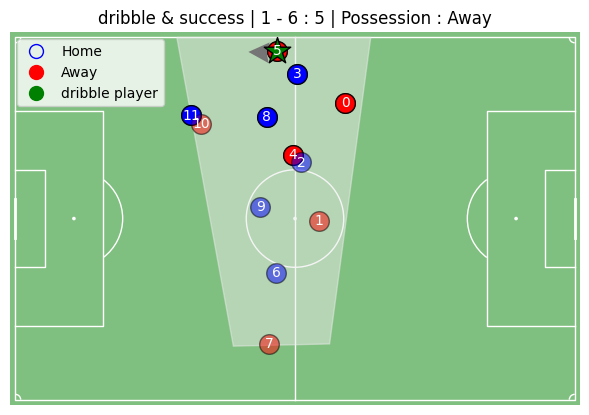

In [29]:
from express.visualization import plot_action

temp_row = game_actions[game_actions['type_name']=='pressing'].iloc[23]
seq_idx_list = list(game_actions[game_actions['period_id'] == temp_row['period_id'] &(game_actions['time_seconds'] >= temp_row['time_seconds']) & (game_actions['time_seconds'] <= temp_row['time_seconds'] + 5)].index)

if game_actions.loc[seq_idx_list[-1]]['type_name'] != 'shot' and seq_idx_list[-1] != game_actions['action_id'].max():
    seq_idx_list.append(seq_idx_list[-1] + 1)

temp_df = game_actions.loc[seq_idx_list]
temp_df = temp_df[temp_df['original_event_id'].notna()]
home_team_id, away_team_id = train_db.get_home_away_team_id(game_id = game_id)

for action_id in temp_df['action_id'].values:
    idx = (game_id, action_id)
    plot_action(actions.loc[idx], home_team_id=home_team_id, prob=None)